In [1]:
import time
import warnings
from functools import partial

import matplotlib as mpl
import numpy as np
from IPython import get_ipython

import pymor.tools.random

ip = get_ipython()
if ip is not None:
#    ip.run_line_magic('matplotlib', 'inline')
    ip.run_line_magic('matplotlib', 'ipympl')

warnings.filterwarnings('ignore', category=UserWarning, module='torch')

pymor.tools.random._default_random_state = None

mpl.rcParams['figure.facecolor'] = (1.0, 1.0, 1.0, 0.0)
#mpl.rcParams['figure.dpi'] = 200

from pymor.core.logger import getLogger, set_log_levels

set_log_levels({ # disable logging for some components
    'main': 'DEBUG',
    'pymor': 'WARN',
    'pymor.models': 'WARN',
    'pymor.discretizers.builtin': 'WARN',
    'pymor.discretizers.dunegdt': 'DEBUG',
    'pymor.analyticalproblems.functions.BitmapFunction': 'ERROR',
    'models.ann.ANNStateReductor': 'INFO',
    'models.vkoga.VkogaStateModel': 'INFO',
    'models.vkoga.VkogaStateReductor': 'DEBUG',
    'models.adaptive': 'DEBUG',
    'algorithms.optimization': 'DEBUG'})

logger = getLogger('main.main')

In [2]:
# FOM
num_refines = 2
num_timesteps = 20

In [3]:
from pymor.basic import *


def setup_problem_and_discretize(num_refines, nt):
    from alternative_spe10channel import discretize, make_problem

    grid, num_grid_elements, boundary_info, problem, parameter_space, mu_bar, darcy_pressure = make_problem(
        regime='diffusion dominated', num_global_refines=num_refines)

    fom, fom_data, coercivity_estimator = discretize(
        grid, num_grid_elements, boundary_info, problem, mu_bar, nt=nt)

    fom_data['darcy_pressure'] = darcy_pressure

    return parameter_space, fom, fom_data, coercivity_estimator


spatial_product = lambda m: m.energy_0_product

In [4]:
logger.info('creating FOM:')
tic = time.perf_counter()

parameter_space, fom, fom_data, coercivity_estimator = setup_problem_and_discretize(
    num_refines, num_timesteps)

fom_offline_time = time.perf_counter() - tic
logger.info(f'  discretizing took {fom_offline_time}s')
logger.info(f'  grid has {fom_data["grid"].size(0)} elements,'
            f'FOM has {fom.solution_space.dim} DoFs, '
            f'uses {fom.time_stepper.nt} time steps')

logger.info(f'  input parameter space is {parameter_space.parameters.dim}-dimensional:')
logger.info(f'    {parameter_space}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

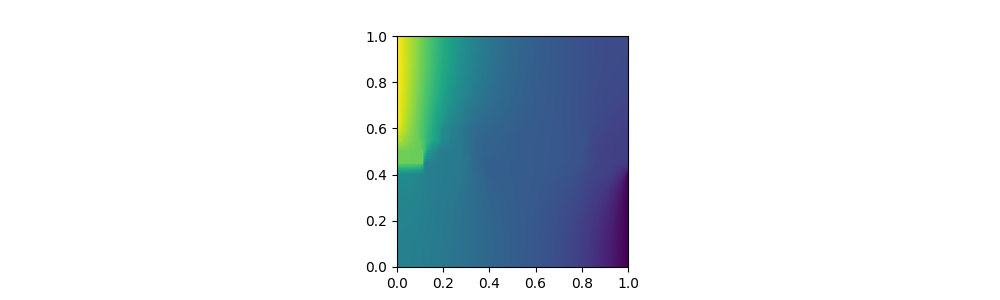

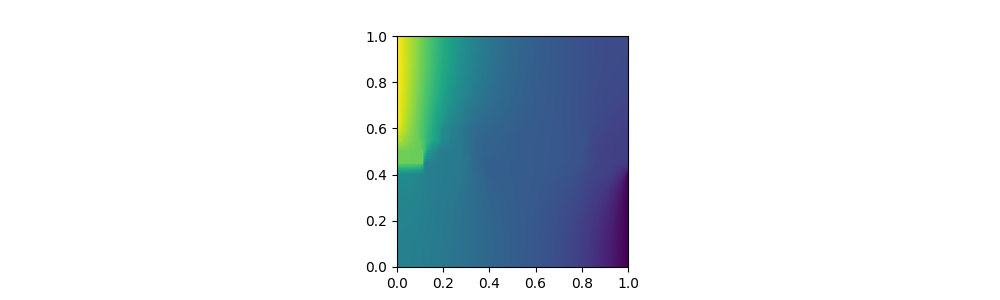

In [5]:
#print(fom_data['darcy_pressure'].impl._list[0].impl.impl)
fom.visualize(np.array(fom_data['darcy_pressure'].impl._list[0].impl.impl))

In [6]:
logger.info('computing dual norm of output functional:')

assert not fom.output_functional.parametric
riesz_representative = spatial_product(fom).apply_inverse(fom.output_functional.as_vector())
dual_norm_output = np.sqrt(spatial_product(fom).apply2(riesz_representative, riesz_representative)[0][0])
del riesz_representative

logger.info(f'  {dual_norm_output}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [7]:
from pymor.models.hierarchy import AdaptiveModelHierarchy

In [8]:
rb_reductor = ParabolicRBReductor(fom, product=spatial_product(fom), coercivity_estimator=coercivity_estimator)

def reduction_rb(training_data, len_previous_training_data, models, reductors):
    U = fom.solution_space.empty(reserve=len(training_data))
    for _, u in training_data[len_previous_training_data:]:
        U.append(u)
    RB, _ = pod(U, product=fom.h1_0_semi_product)
    reductors[0].extend_basis(RB)
    # TODO: Use HaPOD here!!!
    return reductors[0].reduce()

def post_reduction_rb(training_data, models, reductors):
    return []

tolerance = 5e-3

# Settings for the two-stage hierarchy
models = [rb_reductor.reduce(), fom]
model_names = ['RB-ROM', 'FOM']
reductors = [rb_reductor]
reduction_methods = [reduction_rb]
post_reduction_methods = [post_reduction_rb]
training_frequencies = [1]

two_stage_hierarchy = AdaptiveModelHierarchy(models, reductors, reduction_methods, post_reduction_methods,
                                             training_frequencies, tolerance, visualizer=fom.visualizer,
                                             name='Two-stage model hierarchy')

In [9]:
mu_init = fom.parameters.parse([9.5, 9.5])
mu_opt = fom.parameters.parse([3.1647, 11.0])

def objective_function(output, mu):
    return fom.T * np.mean(output)# + 1/500 * mu["Da"][0]**2 - 1/10 * (mu["Pe"][0] - 9.)**2

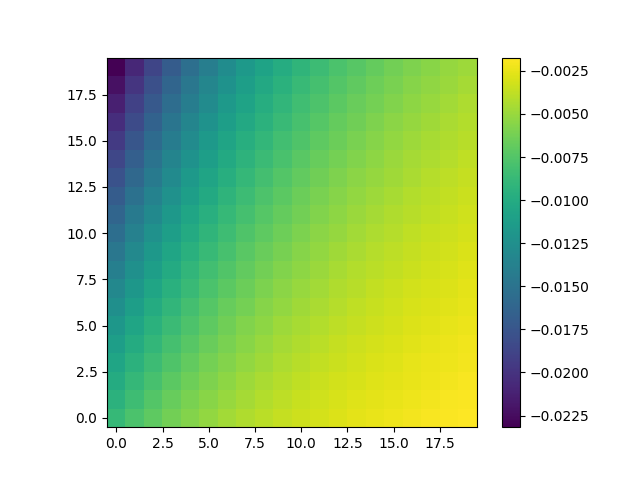

In [10]:

num_params = 20
uniform_params = parameter_space.sample_uniformly(num_params)
res = np.zeros((num_params, num_params))
for i, mu in enumerate(uniform_params):
    output = fom.output(mu).flatten()
    res[(i-(i%num_params))//num_params, i%num_params] = objective_function(output, mu)

import matplotlib.pyplot as plt
plt.close()
fig, axs = plt.subplots()
mp = axs.imshow(res.T, origin='lower')
fig.colorbar(mp, ax=axs)
plt.show()


Minimum value: -0.10317406640698783
Minimum index: (0, 19)
Minimum parameter: {Da: [0.01], Pe: [11.0]}


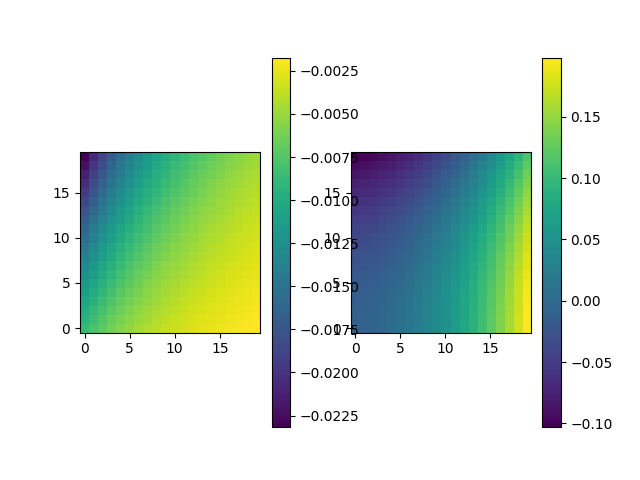

In [11]:

res_alt = res.copy()
params_array = np.array([p.to_numpy() for p in uniform_params]).reshape((num_params, num_params, 2))
s = 1/500
t = 1/50
res_alt += s * params_array[..., 0]**2 - t * (params_array[..., 1] - 9.)**2
#print(f"Matrix of output values: {res_alt}")
print(f"Minimum value: {np.min(res_alt)}")
amin = np.unravel_index(res_alt.argmin(), res_alt.shape)
print(f"Minimum index: {amin}")
print(f"Minimum parameter: {uniform_params[amin[0]*num_params+amin[1]]}")
plt.close()
fig_alt, axs_alt = plt.subplots(1, 2)
mp = axs_alt[0].imshow(res.T, origin='lower')
fig_alt.colorbar(mp, ax=axs_alt[0])
mp_alt = axs_alt[1].imshow(res_alt.T, origin='lower')
fig_alt.colorbar(mp_alt, ax=axs_alt[1])
plt.show()


In [ ]:

fig = plt.figure(frameon=False)
fig.set_size_inches(1, 1)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(res.T, origin='lower', aspect='auto')
fig.savefig('fig_optimization_background_new.png', dpi=100)


In [ ]:
mean = (5.005, 10)
cov = [[2, 0], [0, 1]]

from scipy.stats import multivariate_normal
rv = multivariate_normal(mean, cov)

def random_sampling_function():
    return rv.rvs()

density_function_monte_carlo = rv.pdf

In [ ]:
from pymor.models.interact import interact_model_hierarchy

# Katalytische Filter

Problem description!!!

# Adaptive Modellhierarchien

<style>.myst, .myst p {font-size: 20pt;}</style>

## Modelle

### Full order model (FOM)

### Reduced order model (RB-ROM)

### Machine learning model (ML-ROM)

Description + visualization

| Modell | Genauigkeit | Rechenaufwand | Sonstiges |
|--------|-------------|---------------|-----------|
| FOM    | Hinreichend genau für alle Parameter (Referenzlösung) | Sehr aufwendig | - |
| RB-ROM | Etwas ungenauer als das FOM | Deutlich schneller als das FOM | Effiziente Fehlerschätzung möglich |
| ML-ROM | Ungenauer als das RB-ROM | Schneller als das RB-ROM | Fehlerschätzung vom RB-ROM kann wiederverwendet werden |

In [ ]:
from pymor.reductors.ml import MachineLearningInstationaryReductor

method = 'gpr'
model_parameters = {}

ml_reductor = MachineLearningInstationaryReductor(fom=fom, training_set=None, validation_set=None, method=method, model_parameters=model_parameters, product=fom.h1_0_semi_product)

def reduction_ml(training_data, len_previous_training_data, models, reductors):
    rb_rom = models[1]
    rb_reductor = reductors[1]
    ml_reductor = reductors[0]
    error_estimator = rb_rom.error_estimator
    ml_reductor.reduced_basis = rb_reductor.bases['RB']
    red_dim = len(ml_reductor.reduced_basis)
    training_data = [(mu, np.pad(dat.to_numpy()[0], (0, red_dim - len(dat.to_numpy()[0])),
                                 mode='constant', constant_values=0.))
                     for (mu, dat) in training_data if np.linalg.norm(dat.to_numpy().flatten()) > 1e-10]
    ml_reductor.training_data = training_data
    ml_rom = ml_reductor.reduce()
    return ml_rom.with_(error_estimator=error_estimator, T=rb_rom.T, time_stepper=rb_rom.time_stepper)

def post_reduction_ml(training_data, models, reductors):
    return []

def post_reduction_rb(training_data, models, reductors):
    return [models[0]]
    #return [reduction_ml(training_data[1], None, models, reductors)]

models = [None, rb_reductor.reduce(), fom]
model_names = ['ML-ROM', 'RB-ROM', 'FOM']
reductors = [ml_reductor, rb_reductor]
reduction_methods = [reduction_ml, reduction_rb]
post_reduction_methods = [post_reduction_ml, post_reduction_rb]
training_frequencies = [10, 1]

three_stage_hierarchy = AdaptiveModelHierarchy(models, reductors, reduction_methods, post_reduction_methods,
                                               training_frequencies, tolerance)

In [ ]:
interact_model_hierarchy(three_stage_hierarchy, parameter_space, model_names,
                         output_function=objective_function, objective_function=objective_function, initial_parameter=mu_init, optimal_parameter=mu_opt, optimization_bg_image="fig_optimization_background_new.png", optimization_bg_image_limits=(0.0278514264616242, 0.000111348743739251), show_solution=True, visualizer=fom.visualizer, random_sampling_function=random_sampling_function, density_function_monte_carlo=density_function_monte_carlo, solution_plot_extent=(0, 2.5, 0, 1), language='de',
                         fig_width=17)